<a href="https://colab.research.google.com/github/babybulat/ml-in-aesc-trial/blob/main/task_qlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
#%load_ext autoreload
#%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

## 1. Q-learning in the wild (3 pts)

Here we use the qlearning agent on taxi env from openai gym.
You will need to insert a few agent functions here.

In [73]:
import random,math
import numpy as np
from collections import defaultdict

class QLearningAgent():
  """
    Q-Learning Agent

    Instance variables you have access to
      - self.epsilon (exploration prob)
      - self.alpha (learning rate)
      - self.discount (discount rate aka gamma)

    Functions you should use
      - self.getLegalActions(state)
        which returns legal actions for a state
      - self.getQValue(state,action)
        which returns Q(state,action)
      - self.setQValue(state,action,value)
        which sets Q(state,action) := value

    !!!Important!!!
    NOTE: please avoid using self._qValues directly to make code cleaner
  """
  def __init__(self,alpha,epsilon,discount,getLegalActions):
    "We initialize agent and Q-values here."
    self.getLegalActions= getLegalActions
    self._qValues = defaultdict(lambda:defaultdict(lambda:0))
    self.alpha = alpha
    self.epsilon = epsilon
    self.discount = discount

  def getQValue(self, state, action):
    #print(state)
    #print(action)
    if not (state in self._qValues) or not (action in self._qValues[state]):
        return 0.0
    return self._qValues[state][action]

  def setQValue(self,state,action,value):
    """
      Sets the Qvalue for [state,action] to the given value
    """
    self._qValues[state][action] = value

#---------------------#start of your code#---------------------#

  def getValue(self, state):
    """
      Returns max_action Q(state,action)
      where the max is over legal actions.
    """

    possibleActions = self.getLegalActions(state)
    #If there are no legal actions, return 0.0
    if len(possibleActions) == 0:
            return 0.0

    max_q_value = max([self.getQValue(state, action) for action in possibleActions])
    return max_q_value

  def getPolicy(self, state):
    """
      Compute the best action to take in a state.

    """
    possibleActions = self.getLegalActions(state)

    #If there are no legal actions, return None
    if len(possibleActions) == 0:
            return None
    best_q_value = self.getValue(state)
    best_actions = [action for action in possibleActions if abs(self.getQValue(state, action) - best_q_value) < 1e-10]

    return random.choice(best_actions)

  def getAction(self, state):
    """
      Compute the action to take in the current state, including exploration.

      With probability self.epsilon, we should take a random action.
      otherwise - the best policy action (self.getPolicy).

      HINT: You might want to use util.flipCoin(prob)
      HINT: To pick randomly from a list, use random.choice(list)

    """

    # Pick Action
    possibleActions = self.getLegalActions(state)
    #If there are no legal actions, return None
    if len(possibleActions) == 0:
            return None
    #choose action with epsilon exploration strategy:
    if random.random() < self.epsilon:
            action = random.choice(possibleActions)
    else:
            action = self.getPolicy(state)

    return action

  def update(self, state, action, nextState, reward):
    """
      You should do your Q-Value update here

      NOTE: You should never call this function,
      it will be called on your behalf


    """
    #agent parameters
    gamma = self.discount
    learning_rate = self.alpha

    current_q = self.getQValue(state, action)
    next_max_q = self.getValue(nextState)

    new_q = current_q + learning_rate * (reward + gamma * next_max_q - current_q)
    "*** YOUR CODE HERE ***"
    self.setQValue(state, action, new_q)

In [74]:
import gym
env = gym.make("Taxi-v3")
n_actions = env.action_space.n

In [75]:
def play_and_train(env,agent,t_max=10**4):
    """This function should
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        a = agent.getAction(s)

        next_s,r,done,_ = env.step(a)

        #<train(update) agent for state s>
        agent.update(s, a, next_s, r)

        s = next_s
        total_reward +=r
        if done:break

    return total_reward

In [76]:
agent = QLearningAgent(alpha=0.1,epsilon=0.1,discount=0.99,
                       getLegalActions = lambda s: range(n_actions))

Достигните положительной награды, постройте график

In [77]:
from IPython.display import clear_output


0.01


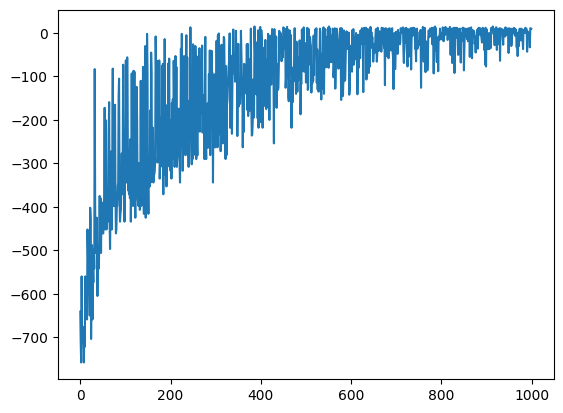

10.0


In [79]:
from IPython.display import clear_output

initial_epsilon = 0.5
final_epsilon = 0.01
decay_rate = 0.995

rewards = []
epsilon_history = []
for i in range(1000):
    rewards.append(play_and_train(env,agent))
    agent.epsilon = max(final_epsilon, initial_epsilon * (decay_rate ** i))
    epsilon_history.append(agent.epsilon)
    if i % 100 ==99:
        clear_output(True)
        print(agent.epsilon)
        plt.plot(rewards)
        plt.show()
print(rewards[-1])


## 3. Continuous state space (2 pt)

Чтобы использовать табличный q-learning на continuous состояниях, надо как-то их обрабатывать и бинаризовать. Придумайте способ разбивки на дискретные состояния.

In [80]:
env = gym.make("CartPole-v0")
n_actions = env.action_space.n
print("first state:%s"%(env.reset()))


first state:[-0.02045577  0.01265089  0.02335878 -0.00332956]


In [81]:
class CartPoleDiscretizer:
    def __init__(self, bins_config=None):
        if bins_config is None:

            self.bins_config = {
                'position': [-1.5, -0.5, 0.5, 1.5],
                'velocity': [-1.0, -0.2, 0.2, 1.0],
                'angle': [-0.2, -0.08, -0.02, 0.02, 0.08, 0.2],
                'angle_velocity': [-1.0, -0.3, 0.3, 1.0]
            }
        else:
            self.bins_config = bins_config


        self.n_bins = {
            'position': len(self.bins_config['position']) + 1,
            'velocity': len(self.bins_config['velocity']) + 1,
            'angle': len(self.bins_config['angle']) + 1,
            'angle_velocity': len(self.bins_config['angle_velocity']) + 1
        }


        self.total_states = (self.n_bins['position'] *
                           self.n_bins['velocity'] *
                           self.n_bins['angle'] *
                           self.n_bins['angle_velocity'])

    def discretize_value(self, value, bins, feature_name):
        for i, threshold in enumerate(bins):
            if value < threshold:
                return i
        return len(bins)

    def discretize(self, state):

        pos_idx = self.discretize_value(state[0], self.bins_config['position'], 'position')
        vel_idx = self.discretize_value(state[1], self.bins_config['velocity'], 'velocity')
        ang_idx = self.discretize_value(state[2], self.bins_config['angle'], 'angle')
        ang_vel_idx = self.discretize_value(state[3], self.bins_config['angle_velocity'], 'angle_velocity')


        return (pos_idx, vel_idx, ang_idx, ang_vel_idx)

    def get_state_index(self, discrete_state):
        pos_idx, vel_idx, ang_idx, ang_vel_idx = discrete_state
        return (pos_idx * self.n_bins['velocity'] * self.n_bins['angle'] * self.n_bins['angle_velocity'] +
                vel_idx * self.n_bins['angle'] * self.n_bins['angle_velocity'] +
                ang_idx * self.n_bins['angle_velocity'] +
                ang_vel_idx)


### Play a few games

Постройте распределения различных частей состояния игры. Сыграйте несколько игр и запишите все состояния.

In [83]:
from collections import defaultdict, Counter
discretizer = CartPoleDiscretizer()

n_episodes = 1000
all_states_continuous = []
all_states_discrete = []
discrete_state_counts = Counter()
state_components_continuous = [[] for _ in range(4)]
state_components_discrete = [[] for _ in range(4)]
episode_rewards = []

for episode in range(n_episodes):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:

        all_states_continuous.append(state)
        for i in range(4):
            state_components_continuous[i].append(state[i])


        discrete_state = discretizer.discretize(state)
        all_states_discrete.append(discrete_state)
        discrete_state_counts[discrete_state] += 1

        for i in range(4):
            state_components_discrete[i].append(discrete_state[i])

        action = env.action_space.sample()

        state, reward, done, _ = env.step(action)
        total_reward += reward

        if done:
            break

    episode_rewards.append(total_reward)
all_states_continuous = np.array(all_states_continuous)
all_states_discrete = np.array(all_states_discrete)


for i in range(4):
    state_components_continuous[i] = np.array(state_components_continuous[i])
    state_components_discrete[i] = np.array(state_components_discrete[i])



## Binarize environment

In [84]:
from gym.core import ObservationWrapper
class Binarizer(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.position_bins = [-1.5, -0.5, 0.5, 1.5]
        self.velocity_bins = [-1.0, -0.2, 0.2, 1.0]
        self.angle_bins = [-0.2, -0.08, -0.02, 0.02, 0.08, 0.2]
        self.angle_velocity_bins = [-1.0, -0.3, 0.3, 1.0]

        self.n_position = len(self.position_bins) + 1
        self.n_velocity = len(self.velocity_bins) + 1
        self.n_angle = len(self.angle_bins) + 1
        self.n_angle_velocity = len(self.angle_velocity_bins) + 1


    def to_bin(self, value, bins):
        for i, threshold in enumerate(bins):
            if value < threshold:
                return i
        return len(bins)

    def observation(self, state):

        pos_idx = self.to_bin(state[0], self.position_bins)
        vel_idx = self.to_bin(state[1], self.velocity_bins)
        ang_idx = self.to_bin(state[2], self.angle_bins)
        ang_vel_idx = self.to_bin(state[3], self.angle_velocity_bins)


        state_idx = (pos_idx * self.n_velocity * self.n_angle * self.n_angle_velocity +
                    vel_idx * self.n_angle * self.n_angle_velocity +
                    ang_idx * self.n_angle_velocity +
                    ang_vel_idx)

        return state_idx

In [85]:
env = Binarizer(gym.make("CartPole-v0"))

## Learn

In [90]:
agent = QLearningAgent(alpha=0.2,epsilon=0.3,discount=0.95,
                       getLegalActions = lambda s: range(n_actions))

0.14553560047327163
195.56
Win!


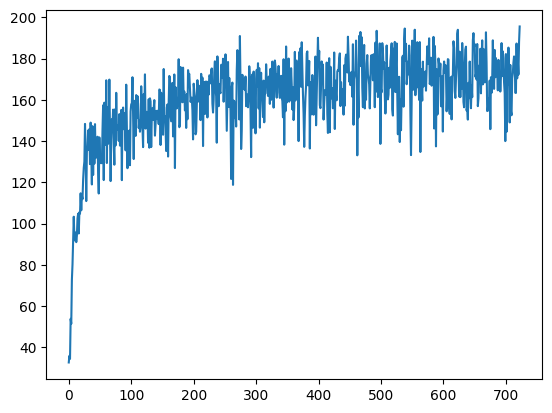

In [91]:
rewards = []
rewBuf = []
ma = -1000000000000

epsilon_decay = 0.999
min_epsilon = 0.05

for i in range(10000):
    for i in range(100):
        rewards.append(play_and_train(env,agent))
    agent.epsilon = max(min_epsilon, agent.epsilon * epsilon_decay)
    rewBuf.append(np.mean(rewards[-100:]))
    clear_output(True)
    print(agent.epsilon)
    print(rewBuf[-1])
    plt.plot(rewBuf)
    if(rewBuf[-1] > 195):
        print("Win!")
        break
    plt.show()


## 4. Experience replay (5 pts)

In [92]:
import random
class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._replaceId = 0


    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize.
        '''
        data = (obs_t, action, reward, obs_tp1, done)
        if len(self._storage) == self._maxsize:
            self._storage[self._replaceId] = data
            self._replaceId = (self._replaceId + 1) % self._maxsize
        else:
            self._storage.append(data)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """

        batch_size = min(batch_size, len(self._storage))

        indices = random.sample(range(len(self._storage)), batch_size)

        states, actions, rewards, next_states, dones = [], [], [], [], []

        for idx in indices:
            s, a, r, ns, d = self._storage[idx]
            states.append(s)
            actions.append(a)
            rewards.append(r)
            next_states.append(ns)
            dones.append(d)

        return (np.array(states),np.array(actions),np.array(rewards, dtype=np.float32),np.array(next_states),np.array(dones, dtype=np.float32))


Some tests to make sure your buffer works right

In [93]:
import numpy as np
replay = ReplayBuffer(2)
obj1 = tuple(range(5))
obj2 = tuple(range(5, 10))
replay.add(*obj1)
assert replay.sample(1)==obj1, "If there's just one object in buffer, it must be retrieved by buf.sample(1)"
replay.add(*obj2)
assert len(replay._storage)==2, "Please make sure __len__ methods works as intended."
replay.add(*obj2)
assert len(replay._storage)==2, "When buffer is at max capacity, replace objects instead of adding new ones."
assert tuple(np.unique(a) for a in replay.sample(100))==obj2
replay.add(*obj1)
assert max(len(np.unique(a)) for a in replay.sample(100))==2
replay.add(*obj1)
assert tuple(np.unique(a) for a in replay.sample(100))==obj1
print ("Success!")

Success!


Now let's use this buffer to improve training:

In [94]:
import gym
env = Binarizer(gym.make('CartPole-v0'))
n_actions = env.action_space.n

In [135]:
agent = QLearningAgent(alpha=0.2,epsilon=0.3,discount=0.95,
                       getLegalActions = lambda s: range(n_actions))
replay = ReplayBuffer(10000)

In [136]:
def play_and_train(env, agent, t_max=10**4, batch_size=10):
    """This function should
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        action = agent.getAction(s)
        next_s, r, done,_ = env.step(action)

        #заполните реплей
        if replay is not None:
            replay.add(s, action, r, next_s, done)
        #опционально - моежте также как в варианте без реплея обучаться по состояниям которые
        #agent.update(s, action, next_s, r)

        s = next_s
        total_reward +=r
        if done:break

    #learn from replay
    if replay is not None and len(replay) >= batch_size:
       states, actions, rewards, next_states, dones = replay.sample(batch_size)

       for i in range(batch_size):
           agent.update(states[i], actions[i], next_states[i], rewards[i])

    return total_reward



Train with experience replay

0.14723081651563868
196.81
Win!


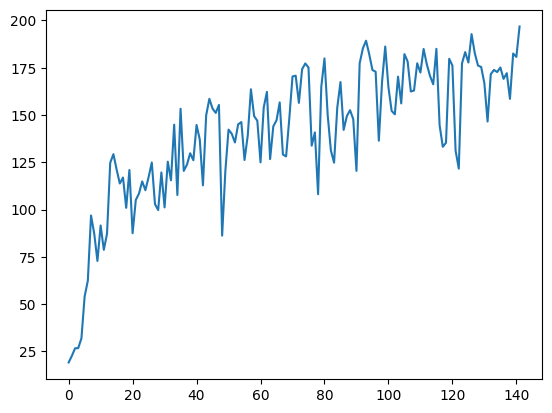

In [137]:
rewards = []
rewBuf = []
ma = -1000000000000

epsilon_decay = 0.995
min_epsilon = 0.01

for i in range(10000):
    for i in range(100):
        rewards.append(play_and_train(env,agent, batch_size=32))
    agent.epsilon =max(min_epsilon, agent.epsilon * epsilon_decay)
    rewBuf.append(np.mean(rewards[-100:]))
    clear_output(True)
    print(agent.epsilon)
    print(rewBuf[-1])
    plt.plot(rewBuf)
    if(rewBuf[-1] > 195):
        print("Win!")
        break
    plt.show()
